In [1]:
import torch
from model import EdgePredictorGNN
from prepare_data import train_loader, val_loader

Created 390012 Data objects, each with 7 nodes, node feature shape torch.Size([7, 2]), and 9 edges.
Train samples: 312009, Validation samples: 78003


In [ ]:
import numpy as np

for batch in train_loader:
    data = batch
    break
#torch.cat((val_preds[0:100], val_targets[0:100]), dim=1)
row, col = data.edge_index
test_x = np.linspace(0, 1001, 1000)
test_x[row]

In [15]:
best_model = 6  # Change this to load a different epoch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 2
hidden_channels = 64
edge_out_channels = 1

# Load model
model = EdgePredictorGNN(in_channels, hidden_channels, edge_out_channels).to(device)
model.load_state_dict(torch.load(f"model_epoch_{best_model}_L1_corrected.pt", map_location=device))
model.eval()

def predict(loader, name):
	all_preds = []
	all_targets = []
	with torch.no_grad():
		for batch in loader:
			batch = batch.to(device)
			pred = model(batch)
			all_preds.append(pred.cpu())
			all_targets.append(batch.edge_attr.cpu())
	preds = torch.cat(all_preds, dim=0)
	targets = torch.cat(all_targets, dim=0)
	mse = torch.mean((preds - targets) ** 2).item()
	print(f"{name} set: MSE = {mse:.6f}")
	return preds, targets

print("Evaluating model...")
train_preds, train_targets = predict(train_loader, "Train")
val_preds, val_targets = predict(val_loader, "Validation")


Evaluating model...
Train set: MSE = 0.493187
Validation set: MSE = 0.495526


In [16]:
ks = ['k01', 'k12', 'k21', 'k23', 'k32', 'k34', 'k45', 'k54', 'k50']
val_kpreds = []
val_ktargets = []
for i, k in enumerate(ks):
    val_kpreds.append(val_preds[i::9])
    val_ktargets.append(val_targets[i::9])

val_preds_corrected = [val_kpreds[0], val_kpreds[1] - val_kpreds[2], val_kpreds[3] - val_kpreds[4], val_kpreds[5], val_kpreds[6] - val_kpreds[7], val_kpreds[8]]
val_targets_corrected = [val_ktargets[0], val_ktargets[1] - val_ktargets[2], val_ktargets[3] - val_ktargets[4], val_ktargets[5], val_ktargets[6] - val_ktargets[7], val_ktargets[8]]

val_preds_final = torch.cat(val_preds_corrected, dim=0)
val_targets_final = torch.cat(val_targets_corrected, dim=0)

train_kpreds = []
train_ktargets = []
for i, k in enumerate(ks):
    train_kpreds.append(train_preds[i::9])
    train_ktargets.append(train_targets[i::9])

train_preds_corrected = [train_kpreds[0], train_kpreds[1] - train_kpreds[2], train_kpreds[3] - train_kpreds[4], train_kpreds[5], train_kpreds[6] - train_kpreds[7], train_kpreds[8]]
train_targets_corrected = [train_ktargets[0], train_ktargets[1] - train_ktargets[2], train_ktargets[3] - train_ktargets[4], train_ktargets[5], train_ktargets[6] - train_ktargets[7], train_ktargets[8]]

train_preds_final = torch.cat(train_preds_corrected, dim=0)
train_targets_final = torch.cat(train_targets_corrected, dim=0)

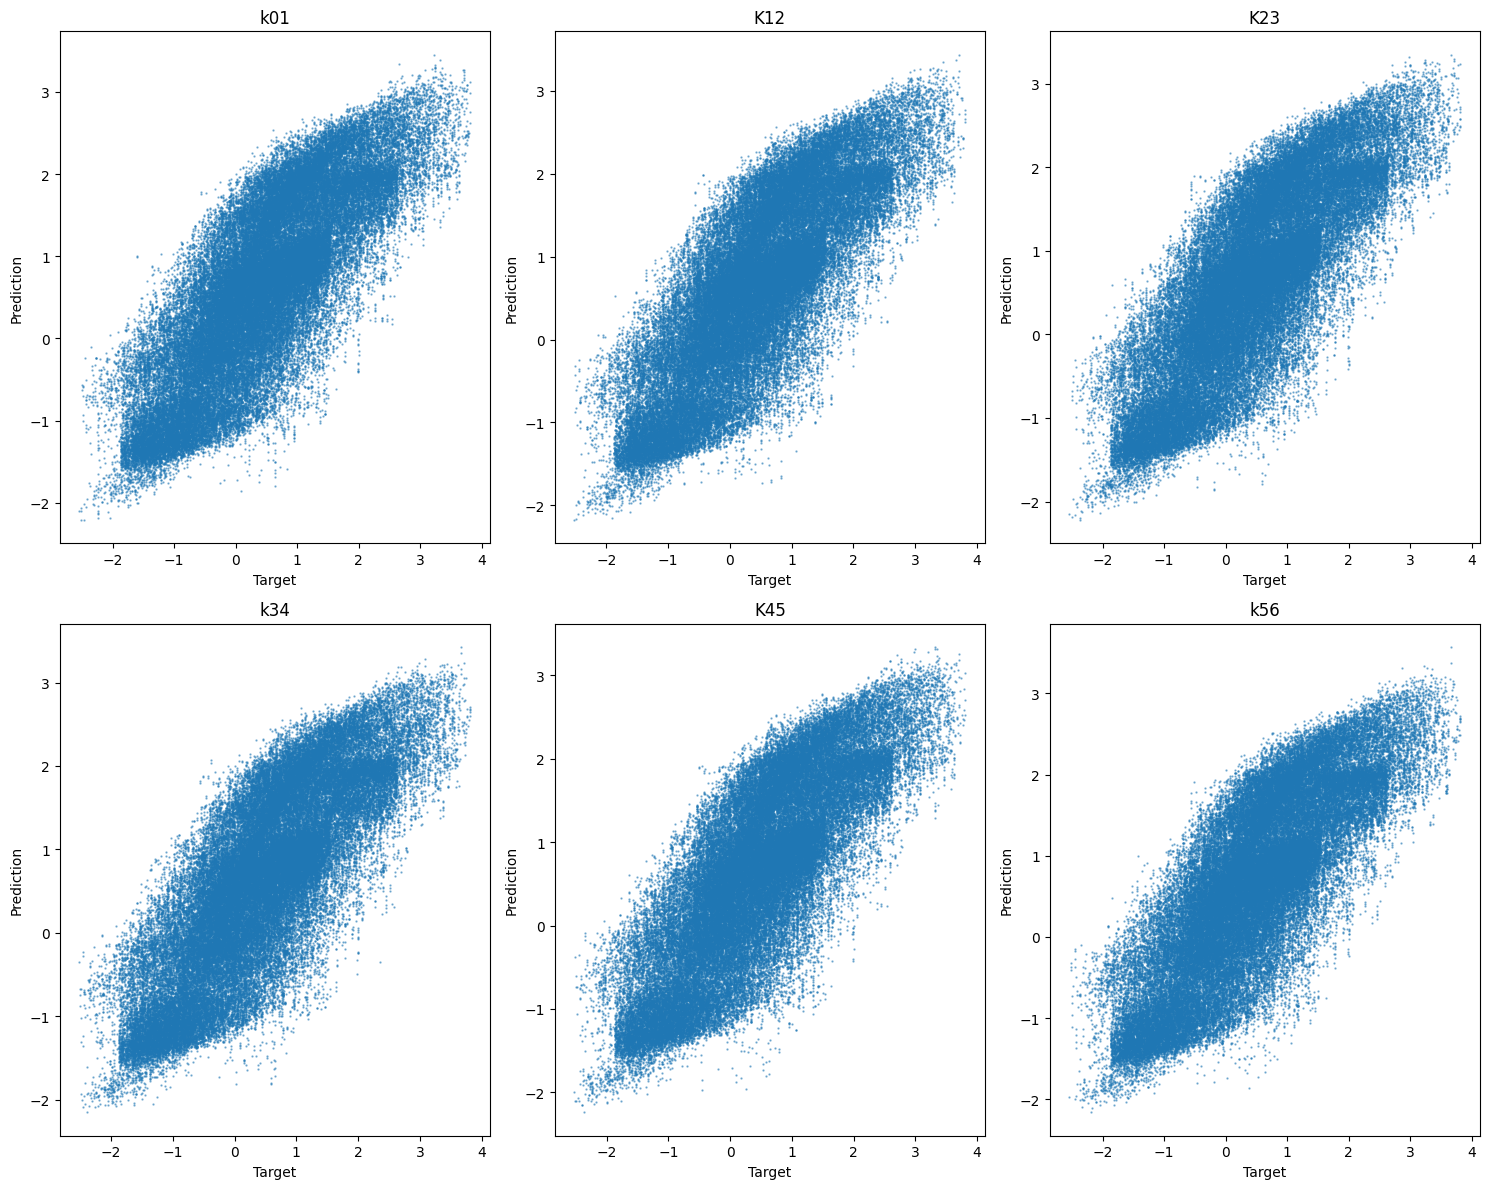

In [17]:
import matplotlib.pyplot as plt

# 6 subplots: scatter for each edge type (assuming 6 edge types)
ks = ['k01', 'K12', 'K23', 'k34', 'K45', 'k56']
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
for i in range(6):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(val_targets_final[i::6], val_preds_final[i::6], s=0.5, alpha=0.5)
    axes[row, col].set_title(ks[i])
    axes[row, col].set_xlabel('Target')
    axes[row, col].set_ylabel('Prediction')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(val_targets_final[0:6], val_preds_final[0:6])

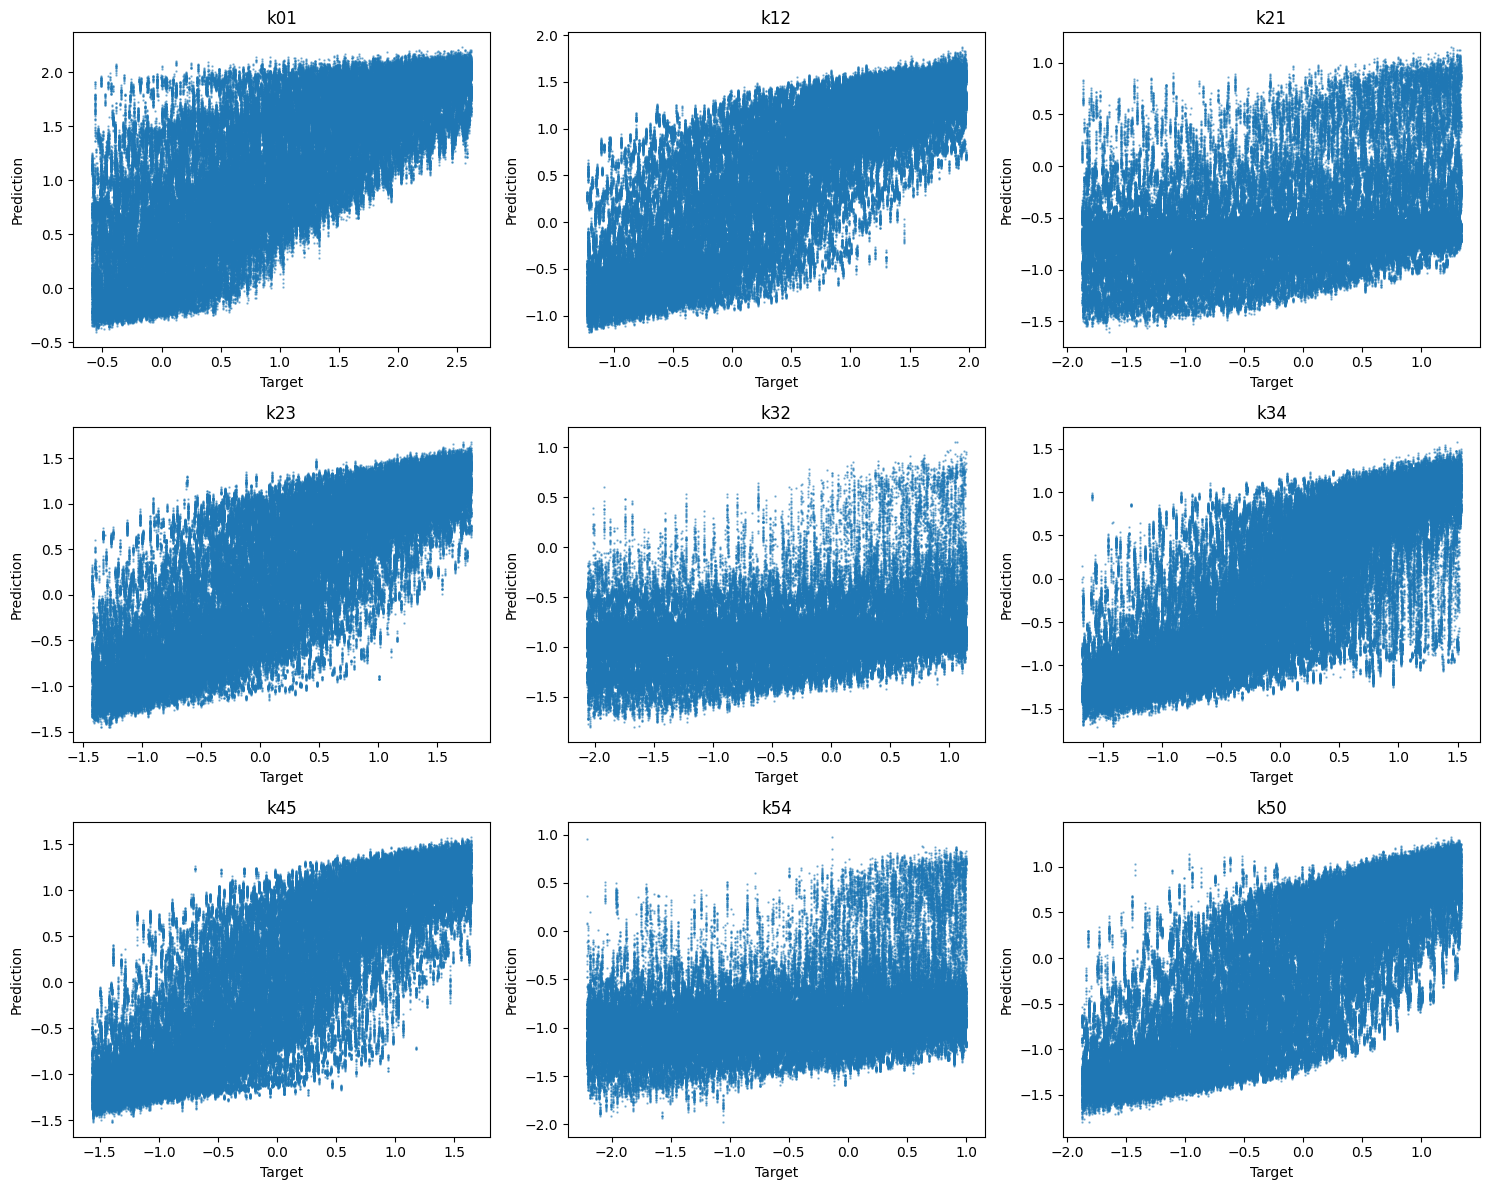

In [19]:
import matplotlib.pyplot as plt

# 9 subplots: scatter for each edge type (assuming 9 edge types)
ks = ['k01', 'k12', 'k21', 'k23', 'k32', 'k34', 'k45', 'k54', 'k50']
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(train_targets[i::9], train_preds[i::9], s=0.5, alpha=0.5)
    axes[row, col].set_title(ks[i])
    axes[row, col].set_xlabel('Target')
    axes[row, col].set_ylabel('Prediction')
plt.tight_layout()
plt.show()

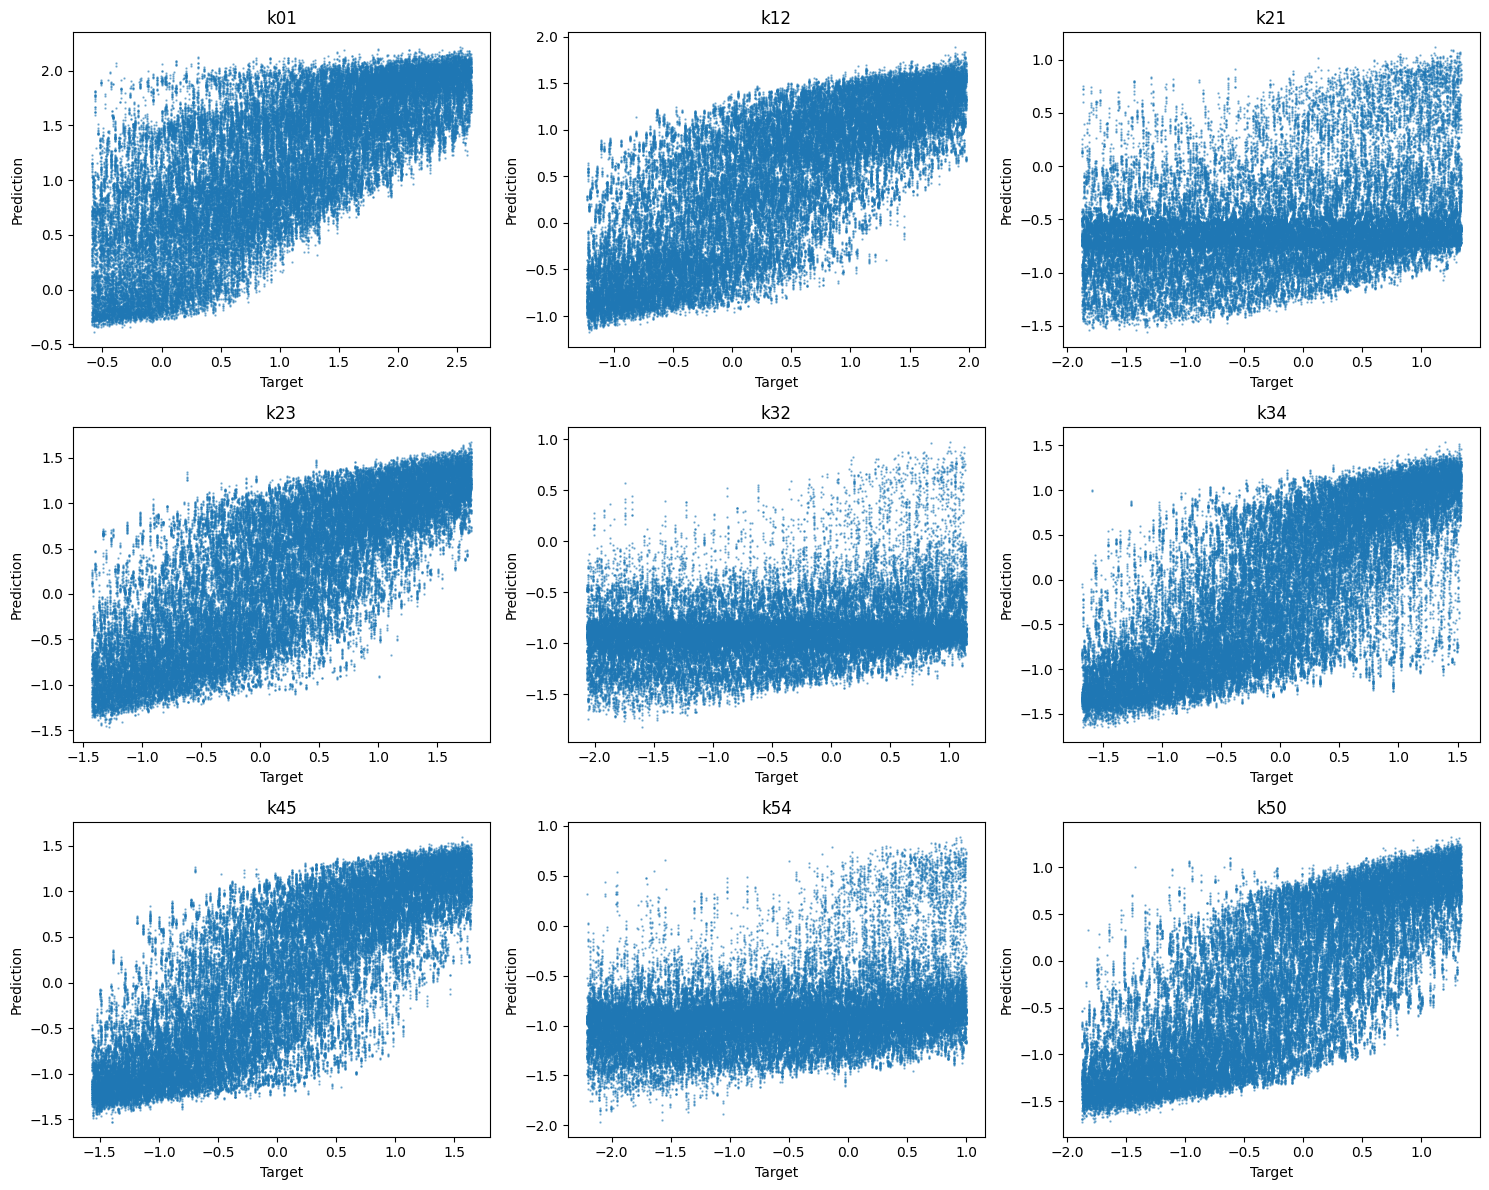

In [18]:
import matplotlib.pyplot as plt

# 9 subplots: scatter for each edge type (assuming 9 edge types)
ks = ['k01', 'k12', 'k21', 'k23', 'k32', 'k34', 'k45', 'k54', 'k50']
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i in range(9):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(val_targets[i::9], val_preds[i::9], s=0.5, alpha=0.5)
    axes[row, col].set_title(ks[i])
    axes[row, col].set_xlabel('Target')
    axes[row, col].set_ylabel('Prediction')
plt.tight_layout()
plt.show()

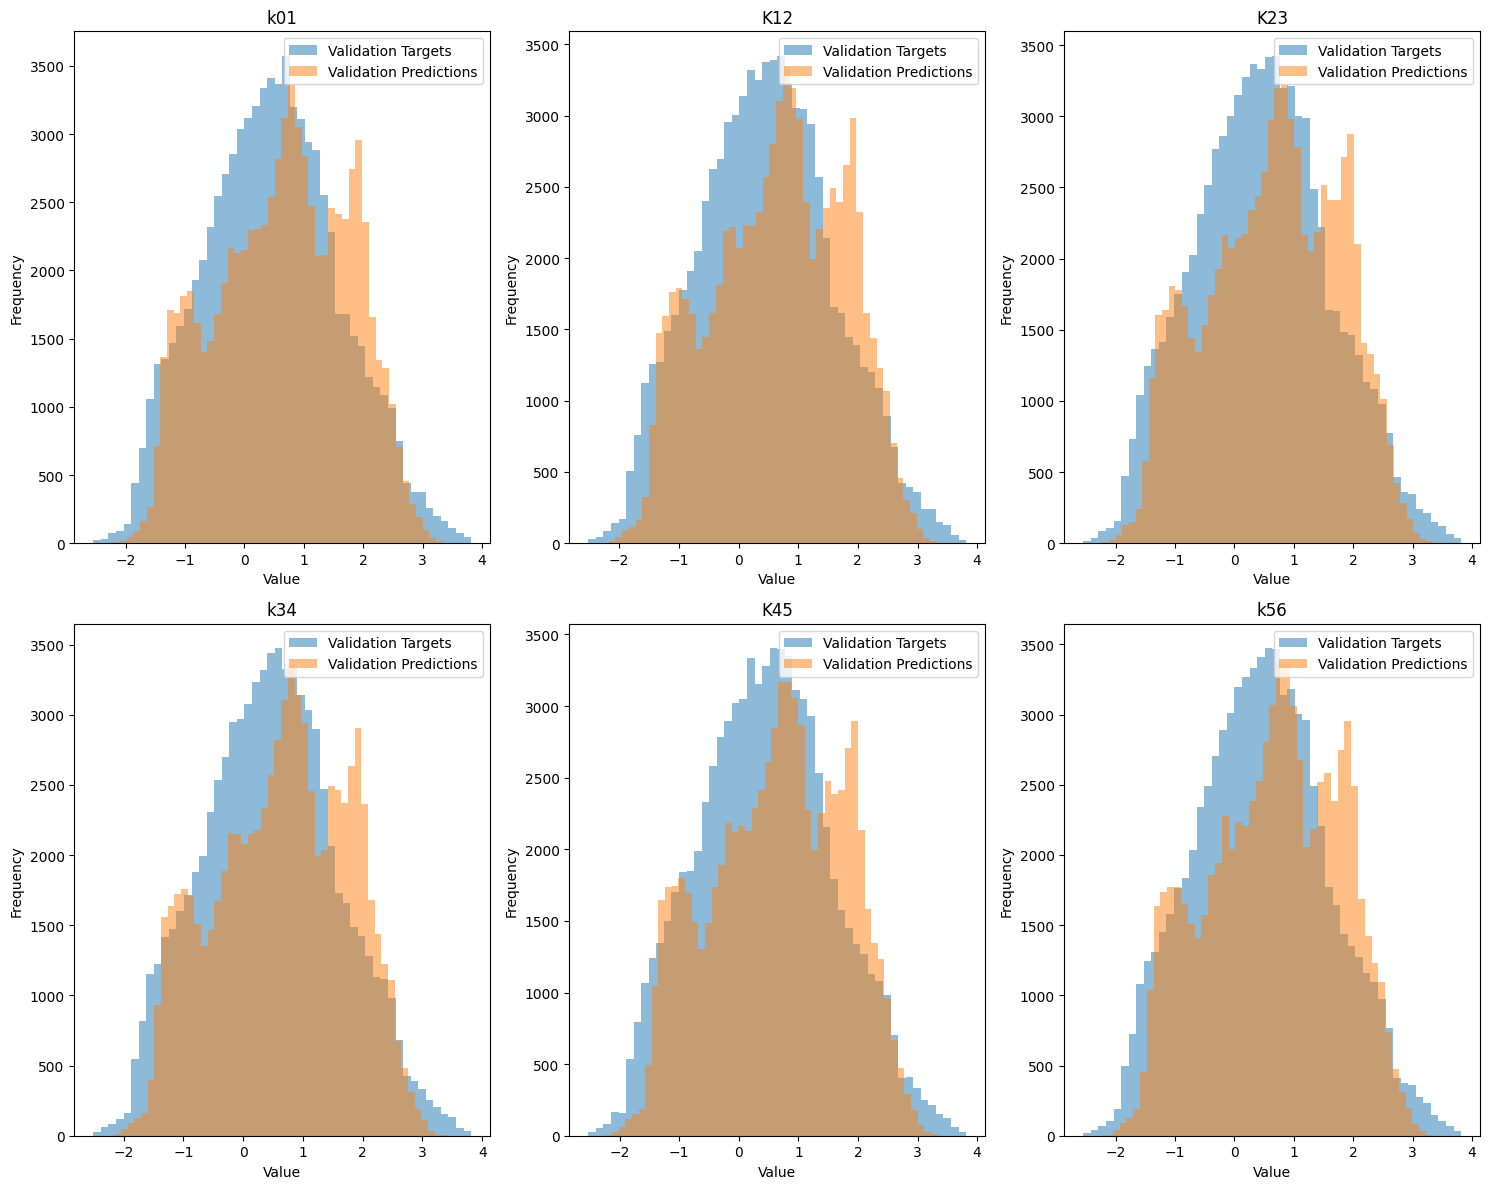

In [20]:
import matplotlib.pyplot as plt
import numpy as np

val_targets_flat = val_targets_final.cpu().numpy().flatten()
val_preds_flat = val_preds_final.cpu().numpy().flatten()

ks = ['k01', 'K12', 'K23', 'k34', 'K45', 'k56']
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
for i in range(6):
    row = i // 3
    col = i % 3
    axes[row, col].hist(val_targets_flat[i::6], bins=50, alpha=0.5, label='Validation Targets')
    axes[row, col].hist(val_preds_flat[i::6], bins=50, alpha=0.5, label='Validation Predictions')
    axes[row, col].set_title(ks[i])
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
plt.legend()
plt.tight_layout()
plt.show()


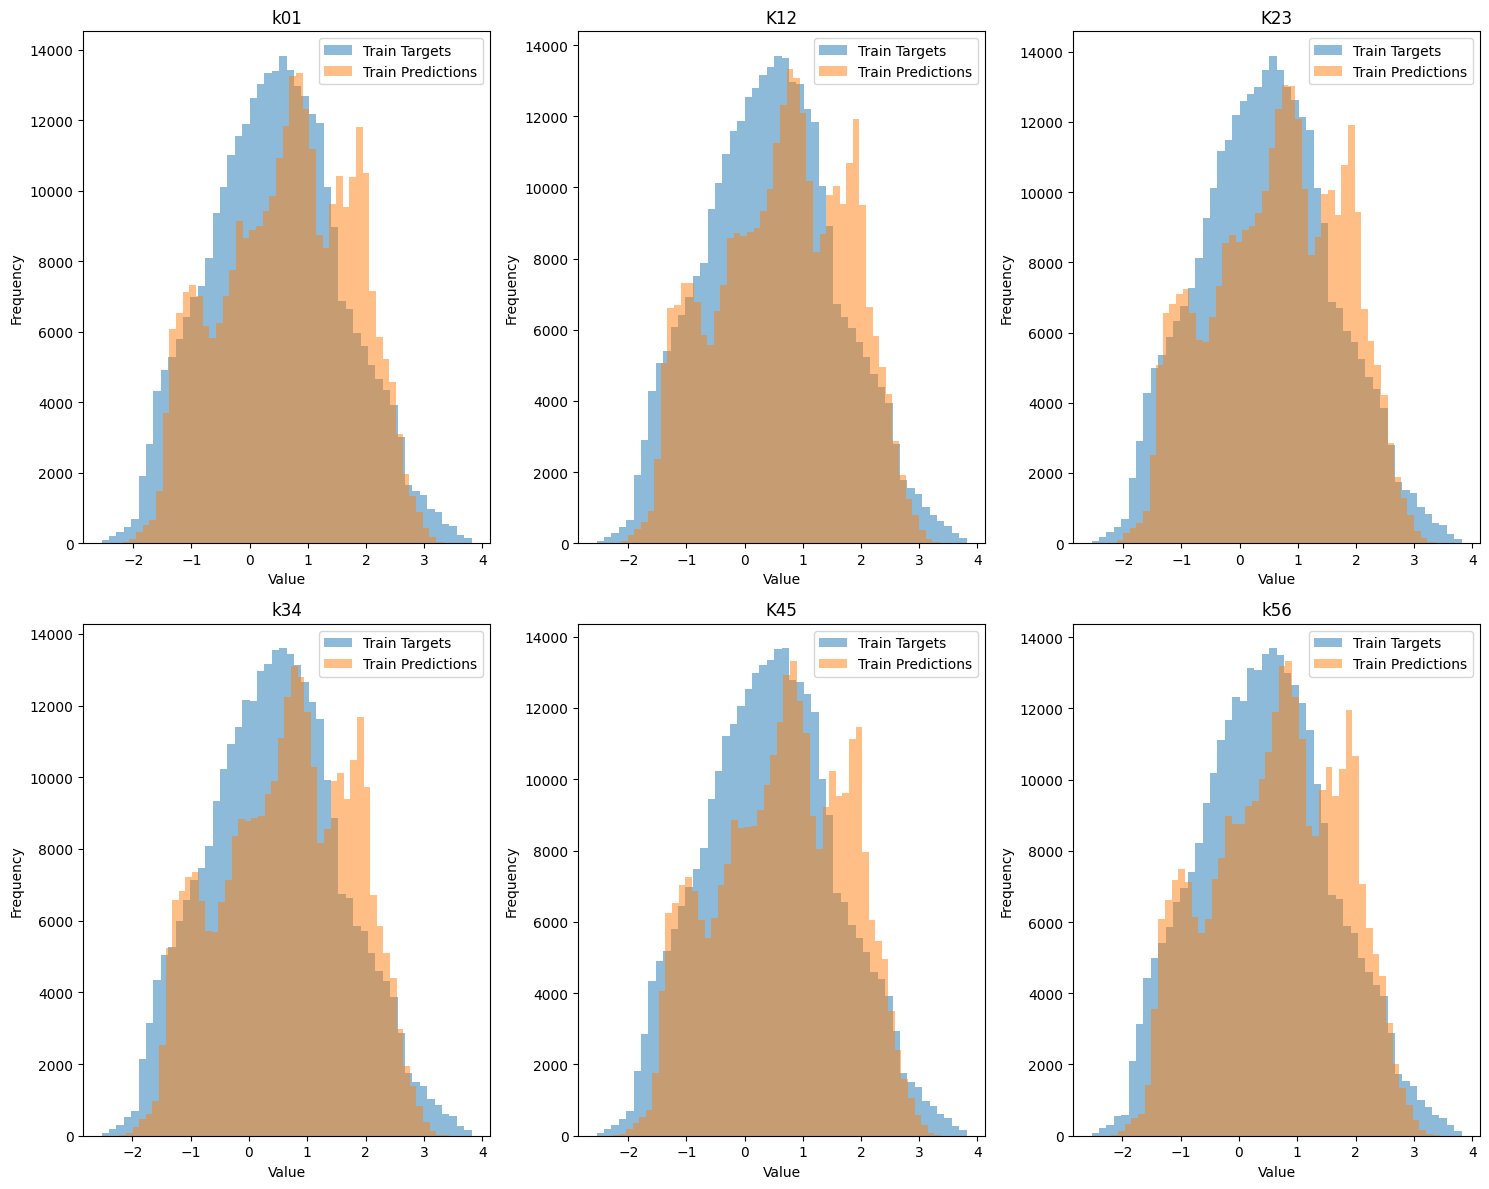

In [21]:
train_targets_flat = train_targets_final.cpu().numpy().flatten()
train_preds_flat = train_preds_final.cpu().numpy().flatten()

ks = ['k01', 'K12', 'K23', 'k34', 'K45', 'k56']
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
for i in range(6):
    row = i // 3
    col = i % 3
    axes[row, col].hist(train_targets_flat[i::6], bins=50, alpha=0.5, label='Train Targets')
    axes[row, col].hist(train_preds_flat[i::6], bins=50, alpha=0.5, label='Train Predictions')
    axes[row, col].set_title(ks[i])
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
plt.legend()
plt.tight_layout()
plt.show()
